# Create checkshot velocity data

### The following script imports data from both an external website (npd.no) and from an exported 
### file out of Petrel.  The data sources are then combined and parameters are calculated from them
### eg. Thickness, one-way-time, interval velocity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import NPD Tops spreadsheet from website

In [2]:
npd_link = r'https://npdfactpages.npd.no/ReportServer_npdpublic?/FactPages/TableView/wellbore_formation_top&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=84.208.221.128&CultureCode=en'

tops = pd.read_csv(npd_link)

columns = list(tops.columns)

rename = ["Well", "MD", "Base", "Surface", "Level", "Parent", "Id", "LithoStrat", "LithoStratParent", "Date", "Sync"]

rename_cols = dict(zip(columns,rename))

tops.rename(columns=rename_cols, inplace=True)

# Remove GP names from the list
#data[ data.duplicated(subset=['Well', 'MD'], keep='last')].Surface.str.contains("GP")
tops = tops[ ~tops['Surface'].str.contains("GP")]

# Remove MBR names from the list
#data[ data.duplicated(subset=['Well', 'MD'], keep='last')].Surface.str.contains("MBR")
tops = tops[ ~tops['Surface'].str.contains("MBR")]

tops.drop(['Level', 'Parent', 'Id', 'LithoStrat', 'LithoStratParent', 'Date', 'Sync'], axis=1, inplace=True)

## Import Petrel tops

In [3]:
petrel_tops = pd.read_csv('tops.csv')

petrel_tops.rename(columns={'Well identifier':'Well', 'Z':'TVDSS','TWT auto':'TWT'}, inplace=True)

petrel_tops.TVDSS = petrel_tops['TVDSS']*-1

# Remove rows that have Surface named in del_rows

del_rows = ['UNDIFFERENTIATED', 'NO FORMAL NAME', 'NO GROUP DEFINED', 'UNDEFINED GP']

for i in range(len(del_rows)):
    petrel_tops = petrel_tops[ petrel_tops.Surface != del_rows[i]]

# Replace misspelled Formation names with correct spelling

typos = {'Surface' : {'STﾘ FM':'STØ FM', 'TUBﾅEN FM':'TUBÅEN FM', '?RRET FM':'ØRRET FM',
         'R?YE FM':'RØYE FM', '?RN FM':'ØRN FM', 'ISBJ?RN FM':'ISBJØRN FM', 'BL坦EROT FM':'BLÆREROT FM'}}

petrel_tops.replace(typos, inplace=True)

### THIS ASSUMES THAT ONLY FORMATION TOPS WILL BE USED ###

# Remove GP names from the list
#data[ data.duplicated(subset=['Well', 'MD'], keep='last')].Surface.str.contains("GP")
petrel_tops = petrel_tops[ ~petrel_tops['Surface'].str.contains("GP")]

# Remove MBR names from the list
#data[ data.duplicated(subset=['Well', 'MD'], keep='last')].Surface.str.contains("MBR")
petrel_tops = petrel_tops[ ~petrel_tops['Surface'].str.contains("MBR")]

## Merge NPD and Petrel dataframes

In [4]:
merge = pd.merge(tops, petrel_tops)

C:\Users\Dunbar\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1100: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [5]:
merge['Thickness'] = merge['Base'] - merge['MD']

In [6]:
wells = list(merge.Well.unique())
well_list = []
for well in wells:
    well = well.replace('/','_')
    well = well.replace('-', '_')
    well = well.replace(" ","")
    well = 'X' + well
    well_list.append(well)
print(well_list)

['X7220_11_3AR', 'X7220_11_1', 'X7220_10_1', 'X7219_12_1', 'X7120_2_3S', 'X7120_2_1', 'X7120_1_4S', 'X7120_1_3', 'X7120_1_1R2']


In [7]:
well_dict = {}
for i,j in zip(well_list, wells):
    well_dict[i]=j
print(well_dict)

{'X7220_11_3AR': '7220/11-3 AR', 'X7220_11_1': '7220/11-1', 'X7220_10_1': '7220/10-1', 'X7219_12_1': '7219/12-1', 'X7120_2_3S': '7120/2-3 S', 'X7120_2_1': '7120/2-1', 'X7120_1_4S': '7120/1-4 S', 'X7120_1_3': '7120/1-3', 'X7120_1_1R2': '7120/1-1 R2'}


In [8]:
def isochron(df):
    frame = pd.DataFrame()
    for k,v in well_dict.items():
        k = df[df['Well']==v].sort_values(by=['MD'])
        k['TWT_d'] = k['TWT'].shift(-1)
        k['Isochron'] = (k['TWT_d'] - k['TWT']) / 2000
        k['Vint'] = k['Thickness'] / k['Isochron']
        frame = frame.append(k)
    return frame

result = isochron(merge)

In [9]:
result[result.Well == '7120/1-1 R2'].head()

,Well,MD,Base,Surface,X,Y,TVDSS,TWT,Thickness,TWT_d,Isochron,Vint
68,7120/1-1 R2,490,692,TORSK FM,475816.56,7980018.58,464.99,575.68,202,757.86,0.091090,2217.587002
61,7120/1-1 R2,692,1106,FRUHOLMEN FM,475816.59,7980015.76,666.96,757.86,414,1067.07,0.154605,2677.791792
60,7120/1-1 R2,1106,2285,SNADD FM,475816.14,7980015.31,1080.96,1067.07,1179,1761.48,0.347205,3395.688426
65,7120/1-1 R2,2285,2315,KOBBE FM,475801.04,7980006.31,2259.77,1761.48,30,1777.62,0.008070,3717.472119
66,7120/1-1 R2,2315,2373,KLAPPMYSS FM,475800.09,7980005.89,2289.75,1777.62,58,1805.59,0.013985,4147.300679


### Checking results for a Formation (Snadd, Kobbe, Orn, Orret, Roye)

In [10]:
result[result['Surface']=='SNADD FM']

,Well,MD,Base,Surface,X,Y,TVDSS,TWT,Thickness,TWT_d,Isochron,Vint
7,7220/11-3 AR,601,1982,SNADD FM,483739.89,7991462.08,575.97,720.98,1381,1552.74,0.415880,3320.669424
8,7220/11-1,580,1852,SNADD FM,484390.24,7995617.97,549.99,659.19,1272,1531.82,0.436315,2915.324937
23,7220/10-1,2303,2405,SNADD FM,467503.90,7991178.85,2268.99,1794.16,102,NaN,NaN,NaN
28,7120/2-3 S,2563,2625,SNADD FM,477676.44,7965806.20,2535.17,1983.12,62,NaN,NaN,NaN
39,7120/2-1,613,1933,SNADD FM,481920.18,7987310.83,589.87,708.53,1320,1577.85,0.434660,3036.856394
46,7120/1-4 S,733,2274,SNADD FM,471248.15,7982515.38,702.98,797.19,1541,1763.32,0.483065,3190.046888
54,7120/1-3,1101,2203,SNADD FM,474680.07,7978470.92,1076.98,1073.31,1102,1728.17,0.327430,3365.604862
60,7120/1-1 R2,1106,2285,SNADD FM,475816.14,7980015.31,1080.96,1067.07,1179,1761.48,0.347205,3395.688426


## Import Checkshot corrected sonic logs

In [11]:
file1 = r'./sonic_logs/7120_1-1R2_TDR_CalTDR_DTvp-RHOB_CSDea'
data1 = pd.read_csv(file1, sep='\s+', skiprows=14, header=None, na_values='-999')
data1 = data1.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data1.TVDSS = data1['TVDSS']*-1
data1.TWT = data1['TWT']*-1

In [12]:
file2 = r'./sonic_logs/7120_1-3_TDR_CalTDR_DTvp_CS-DEA_Corr1400-1900ms_BSp6ms'
data2 = pd.read_csv(file2, sep='\s+', skiprows=14, header=None, na_values='-999')
data2 = data2.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data2.TVDSS = data2['TVDSS']*-1
data2.TWT = data2['TWT']*-1

In [13]:
file3 = r'./sonic_logs/7120_1-4S_TDR_CalTDR_DTvp_DEN_CSDea_BS0ms'
data3 = pd.read_csv(file3, sep='\s+', skiprows=14, header=None, na_values='-999')
data3 = data3.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data3.TVDSS = data3['TVDSS']*-1
data3.TWT = data3['TWT']*-1

In [14]:
file4 = r'./sonic_logs/7120_1-5_TDR_CalTDR_AC-DEN_CSDiskos'
data4 = pd.read_csv(file4, sep='\s+', skiprows=14, header=None, na_values='-999')
data4 = data4.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data4.TVDSS = data4['TVDSS']*-1
data4.TWT = data4['TWT']*-1

In [15]:
file5 = r'./sonic_logs/7120_2-1_TDR_CalTDR_DTvp-RHOB_BS0ms'
data5 = pd.read_csv(file5, sep='\s+', skiprows=14, header=None, na_values='-999')
data5 = data5.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data5.TVDSS = data5['TVDSS']*-1
data5.TWT = data5['TWT']*-1

In [16]:
file6 = r'./sonic_logs/7120_2-2_TDR_CalTDR_LN17_EW'
data6 = pd.read_csv(file6, sep='\s+', skiprows=14, header=None, na_values='-999')
data6 = data6.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data6.TVDSS = data6['TVDSS']*-1
data6.TWT = data6['TWT']*-1

In [17]:
file7 = r'./sonic_logs/7120_2-3S_TDR_CalTDR_EW1500-2006_BS0ms'
data7 = pd.read_csv(file7, sep='\s+', skiprows=14, header=None, na_values='-999')
data7 = data7.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data7.TVDSS = data7['TVDSS']*-1
data7.TWT = data7['TWT']*-1

In [18]:
file8 = r'./sonic_logs/7219_12-1_TDR_CalTDR_AC_CSDiskos'
data8 = pd.read_csv(file8, sep='\s+', skiprows=14, header=None, na_values='-999')
data8 = data8.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data8.TVDSS = data8['TVDSS']*-1
data8.TWT = data8['TWT']*-1

In [19]:
file9 = r'./sonic_logs/7219_12-3S_TDR_CalTDR'
data9 = pd.read_csv(file9, sep='\s+', skiprows=14, header=None, na_values='-999')
data9 = data9.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data9.TVDSS = data9['TVDSS']*-1
data9.TWT = data9['TWT']*-1

In [20]:
file10 = r'./sonic_logs/7220_10-1_TDR_CalTDR_AC_CSDea_EW'
data10 = pd.read_csv(file10, sep='\s+', skiprows=14, header=None, na_values='-999')
data10 = data10.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data10.TVDSS = data10['TVDSS']*-1
data10.TWT = data10['TWT']*-1

In [21]:
file11 = r'./sonic_logs/7220_11-1_TDR_CalTDR_AC-RHOB_CSDea'
data11 = pd.read_csv(file11, sep='\s+', skiprows=14, header=None, na_values='-999')
data11 = data11.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data11.TVDSS = data11['TVDSS']*-1
data11.TWT = data11['TWT']*-1

In [22]:
file12 = r'./sonic_logs/7220_11-2_TDR_CalTDR_AC-DEN_LN17_CS'
data12 = pd.read_csv(file12, sep='\s+', skiprows=14, header=None, na_values='-999')
data12 = data12.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data12.TVDSS = data12['TVDSS']*-1
data12.TWT = data12['TWT']*-1

In [23]:
file13 = r'./sonic_logs/7220_11-3AR_TDR_CalTDR_AC-DEN_LN17_BS0ms'
data13 = pd.read_csv(file13, sep='\s+', skiprows=14, header=None, na_values='-999')
data13 = data13.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data13.TVDSS = data13['TVDSS']*-1
data13.TWT = data13['TWT']*-1

In [24]:
file14 = r'./sonic_logs/7220_11-4_TDR_CalTDR_AC-DEN_LN17_CSDea'
data14 = pd.read_csv(file14, sep='\s+', skiprows=14, header=None, na_values='-999')
data14 = data14.rename(columns=({0:'X', 1:'Y', 2:'TVDSS', 3:'TWT', 4:'MD', 5:'Well', 6:'Vavg', 7:'Vint'}))
data14.TVDSS = data14['TVDSS']*-1
data14.TWT = data14['TWT']*-1

In [25]:
data1.shape

(904, 8)

In [26]:
colors = ["red", "blue", "green", "orange", "black", "purple", "pink", "teal"]

def velocity_logs(top_depth, bottom_depth):
    
    logs=data1[(data1.TVDSS >= top_depth) & (data1.TVDSS <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(15,15), sharey=True)
    fig.suptitle("Alta", fontsize=22)
    fig.subplots_adjust(top=0.9,wspace=0.1)

#General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False)
#        for (i,j) in zip(W7120_1_1_R2['TVDSS'], W7120_1_1_R2['Surface']):
#            if ((i>=top_depth) and (i<=bottom_depth)):
#                axes.axhline(y=i, linewidth=0.5, color='black')
#                axes.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')



    ax[0]=ax[0].twiny()
    ax[0].grid(True)
    ax[0].set_xlim(0,7000)
    ax[0].spines['top'].set_position(('outward',0))
    ax[0].set_xlabel('Vint[m/s]')
    ax[0].plot(data1.Vint, data1.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[0].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[0].tick_params(axis='x', colors=colors[0])
    ax[0].set_xlabel('Vavg[m/s]')
    ax[0].plot(data1.Vavg, data1.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[0].set_xlabel('Vavg[m/s]', color=colors[1])

    ax[1]=ax[1].twiny()
    ax[1].grid(True)
    ax[1].set_xlim(0,7000)
    ax[1].spines['top'].set_position(('outward',0))
    ax[1].set_xlabel('Vint[m/s]')
    ax[1].plot(data2.Vint, data2.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[1].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[1].tick_params(axis='x', colors=colors[0])
    ax[1].set_xlabel('Vavg[m/s]')
    ax[1].plot(data2.Vavg, data2.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[1].set_xlabel('Vavg[m/s]', color=colors[1])
    
    ax[2]=ax[2].twiny()
    ax[2].grid(True)
    ax[2].set_xlim(0,7000)
    ax[2].spines['top'].set_position(('outward',0))
    ax[2].set_xlabel('Vint[m/s]')
    ax[2].plot(data3.Vint, data3.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[2].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[2].tick_params(axis='x', colors=colors[0])
    ax[2].set_xlabel('Vavg[m/s]')
    ax[2].plot(data3.Vavg, data3.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[2].set_xlabel('Vavg[m/s]', color=colors[1])

    ax[3]=ax[3].twiny()
    ax[3].grid(True)
    ax[3].set_xlim(0,7000)
    ax[3].spines['top'].set_position(('outward',0))
    ax[3].set_xlabel('Vint[m/s]')
    ax[3].plot(data4.Vint, data4.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[3].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[3].tick_params(axis='x', colors=colors[0])
    ax[3].set_xlabel('Vavg[m/s]')
    ax[3].plot(data4.Vavg, data4.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[3].set_xlabel('Vavg[m/s]', color=colors[1])

    ax[4]=ax[4].twiny()
    ax[4].grid(True)
    ax[4].set_xlim(0,7000)
    ax[4].spines['top'].set_position(('outward',0))
    ax[4].set_xlabel('Vint[m/s]')
    ax[4].plot(data5.Vint, data5.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[4].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[4].tick_params(axis='x', colors=colors[0])
    ax[4].set_xlabel('Vavg[m/s]')
    ax[4].plot(data5.Vavg, data5.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[4].set_xlabel('Vavg[m/s]', color=colors[1])

    ax[5]=ax[5].twiny()
    ax[5].grid(True)
    ax[5].set_xlim(0,7000)
    ax[5].spines['top'].set_position(('outward',0))
    ax[5].set_xlabel('Vint[m/s]')
    ax[5].plot(data6.Vint, data6.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[5].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[5].tick_params(axis='x', colors=colors[0])
    ax[5].set_xlabel('Vavg[m/s]')
    ax[5].plot(data6.Vavg, data6.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[5].set_xlabel('Vavg[m/s]', color=colors[1])

    ax[6]=ax[6].twiny()
    ax[6].grid(True)
    ax[6].set_xlim(0,7000)
    ax[6].spines['top'].set_position(('outward',0))
    ax[6].set_xlabel('Vint[m/s]')
    ax[6].plot(data7.Vint, data7.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[6].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[6].tick_params(axis='x', colors=colors[0])
    ax[6].set_xlabel('Vavg[m/s]')
    ax[6].plot(data7.Vavg, data7.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[6].set_xlabel('Vavg[m/s]', color=colors[1])

    ax[7]=ax[7].twiny()
    ax[7].grid(True)
    ax[7].set_xlim(0,7000)
    ax[7].spines['top'].set_position(('outward',0))
    ax[7].set_xlabel('Vint[m/s]')
    ax[7].plot(data8.Vint, data8.TVDSS, label='Vint[m/s]', color=colors[0])
    ax[7].set_xlabel('Vint[m/s]', color=colors[0])    
    ax[7].tick_params(axis='x', colors=colors[0])
    ax[7].set_xlabel('Vavg[m/s]')
    ax[7].plot(data8.Vavg, data8.TVDSS, label='Vavg[m/s]', color=colors[1])
    ax[7].set_xlabel('Vavg[m/s]', color=colors[1])



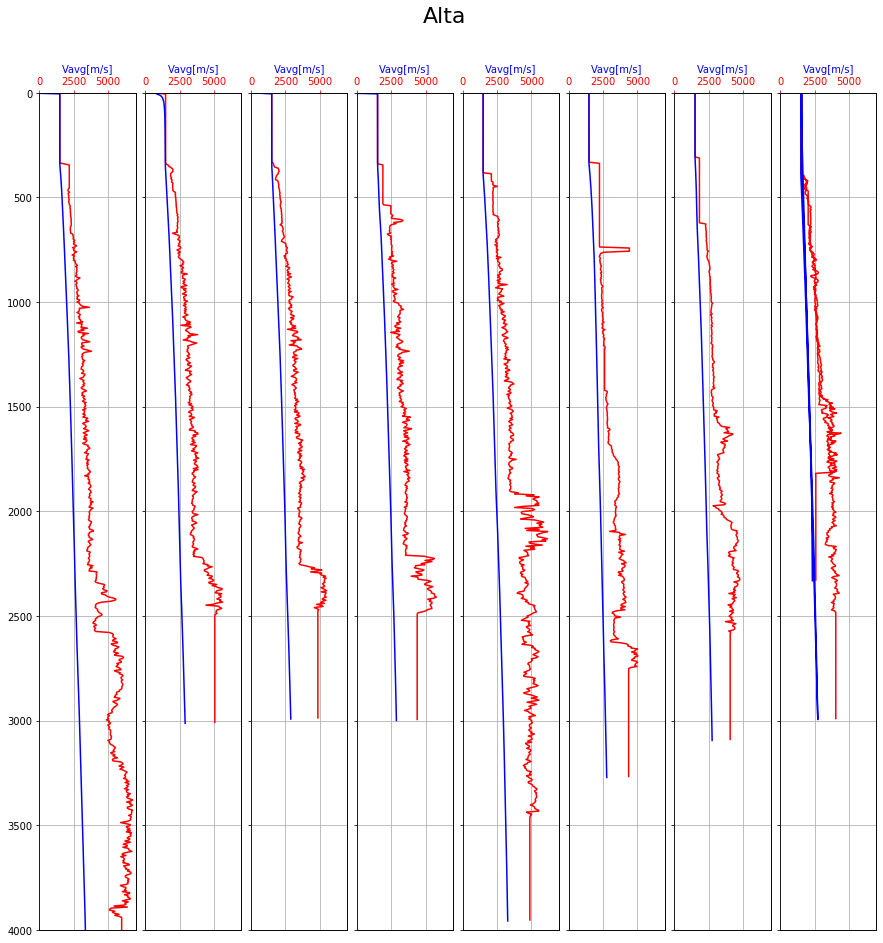

In [27]:
velocity_logs(0, 4000)